<a href="https://colab.research.google.com/github/adrianoracano/Prog-NAPDE/blob/main/prova_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/My Drive

/gdrive/My Drive


In [3]:
!git clone https://github.com/adrianoracano/Prog-NAPDE.git

fatal: destination path 'Prog-NAPDE' already exists and is not an empty directory.


In [4]:
%cd /gdrive/My Drive/Prog-NAPDE

/gdrive/My Drive/Prog-NAPDE


In [5]:
import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt

np.random.seed(123)
tf.random.set_seed(123)

## ODE-NN


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(123)
tf.random.set_seed(123)

In [7]:
# initial condition
f0 = 1
# infinitesimal small number
inf_s = np.sqrt(np.finfo(np.float32).eps)

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = training_steps/10

# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons

weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_output]))
}

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [8]:
# Create model
def multilayer_perceptron(x):
    x = np.array([[[x]]],  dtype='float32')
    # Hidden fully connected layer with 32 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden fully connected layer with 32 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    # Output fully connected layer
    output = tf.matmul(layer_2, weights['out']) + biases['out']
    return output

# Universal Approximator
def g(x):
    return x * multilayer_perceptron(x) + f0

# Given EDO
def f(x):
    return 2*x
    
# Custom loss function to approximate the derivatives
def custom_loss():
    summation = []
    for x in np.linspace(0,1,10):
        dNN = (g(x+inf_s)-g(x))/inf_s
        summation.append((dNN - f(x))**2)
    return tf.reduce_sum(tf.abs(summation))

In [9]:
def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [10]:
for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

loss: 4216.851074 
loss: 4.348598 
loss: 4.212492 
loss: 4.128182 
loss: 4.046163 
loss: 3.928887 
loss: 3.629016 
loss: 1.611184 
loss: 0.089094 
loss: 0.018557 


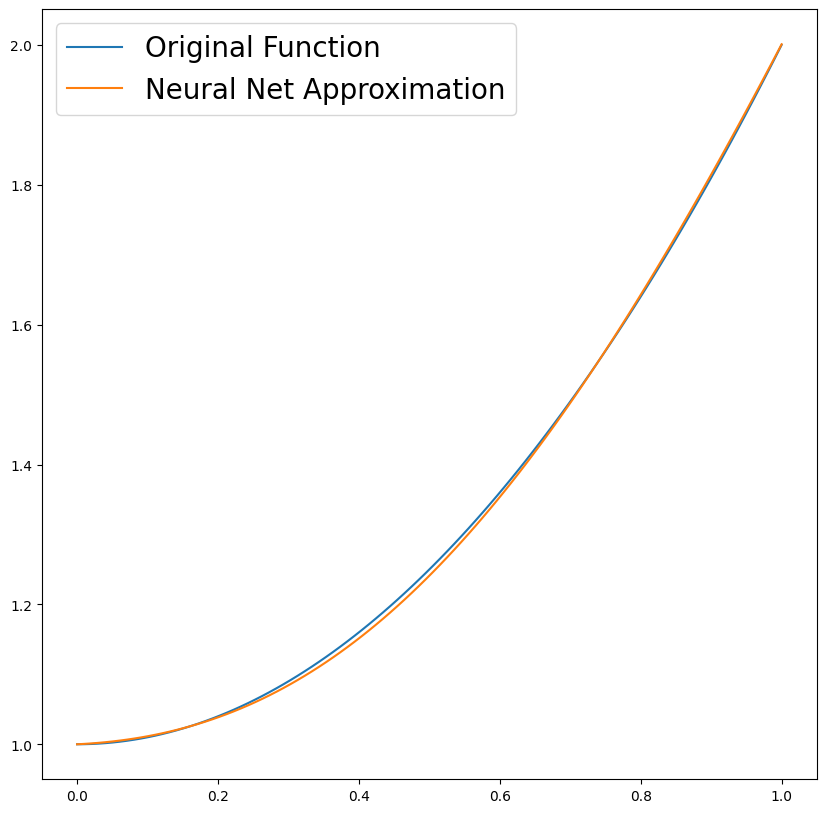

In [11]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
# True Solution (found analitically)
def true_solution(x):
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
  # result.append(f(i))
  result.append(g(i).numpy()[0][0][0])

S = true_solution(X)
  
plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()

##Ode ffnn



In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


In [7]:
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = training_steps/10

In [8]:
# Build the neural network layer by layer
input_layer = tfkl.Input(shape=(1), name='Input')
hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1')(input_layer)
hidden_layer2 = tfkl.Dense(units=64, activation='relu', name='Hidden2')(hidden_layer1)
output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(hidden_layer2)

# Connect input and output through the Model class
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN')

In [15]:
y = np.array([[1]])
model(y).numpy()[0][0]

0.041242518

In [16]:
optimizer = tfk.optimizers.SGD(learning_rate=1e-2)

In [12]:
# Universal Approximator
def g(x):
    return x * model(np.array([x])) + f0
    
def custom_loss():
    summation = []
    for x in np.linspace(0,1,10):
        dNN = (g(x+inf_s)-g(x))/inf_s
        summation.append((dNN - f(x))**2)
    return tf.reduce_sum(tf.abs(summation))

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [13]:
for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

NameError: ignored

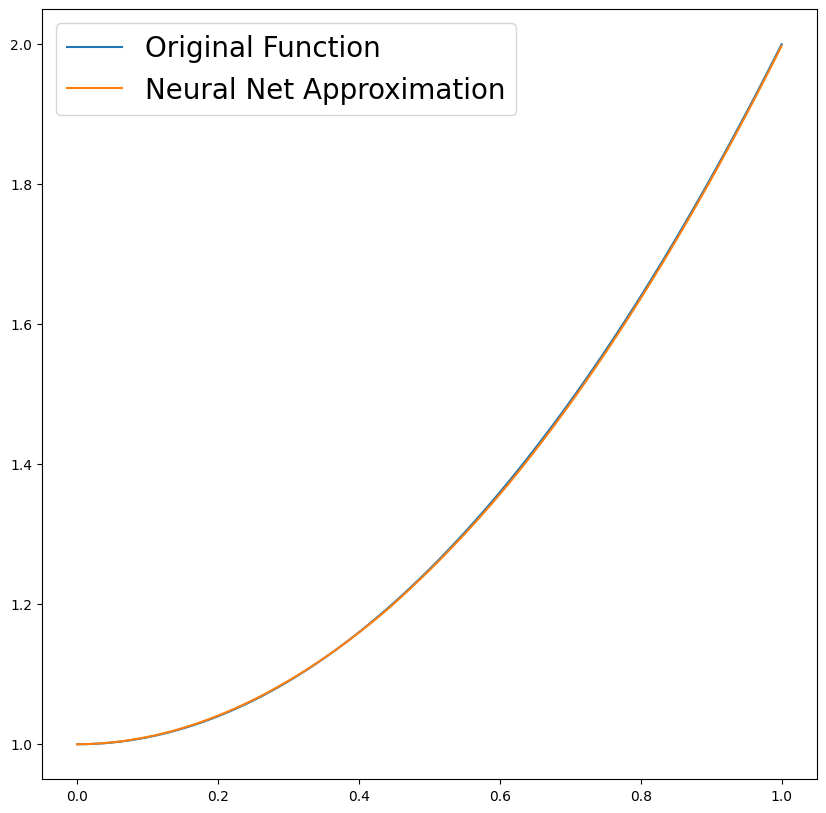

In [48]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
# True Solution (found analitically)
def true_solution(x):
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
  # result.append(f(i))
  result.append(g(i).numpy()[0][0])

S = true_solution(X)
  
plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()

##ffnn nostro problema

In [8]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


In [9]:
input_layer = tfkl.Input(shape=(2), name='Input')
hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1')(input_layer)
hidden_layer2 = tfkl.Dense(units=64, activation='relu', name='Hidden2')(hidden_layer1)
output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(hidden_layer2)

# Connect input and output through the Model class
model2 = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN2')

In [10]:
optimizer = tfk.optimizers.SGD(learning_rate=1e-2)

In [11]:
model2(np.array([[1,2]])).numpy()[0][0]


0.38294485

In [12]:
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = training_steps/10

In [13]:
tau = 365
def g2(beta, T):
    x = np.array([[beta, T]])
    #return x * multilayer_perceptron(x)
    return model2(x)
def beta_eq(T):
    return (35 - T)/T
def T(t):
    return math.exp(-(t - 180)**2/(2*80**2))/(math.sqrt(2*math.pi)*80)*300*5*2.6 + 5 
def dbeta(beta, t):
    return 1/tau*(beta_eq(T(t)) - beta[0])
def dbeta_hat(beta, t):
    return g(beta[0], T(t))

sys = [dbeta]    

t_max=2.0
N=500
beta0=np.array([0.5])
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
dt = t_max /N

In [14]:
g2(1,2)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.38294485]], dtype=float32)>

In [15]:
def custom_loss2():
    curr_beta = beta0[0]
    next_beta = curr_beta
    summation = []
    for i in range(len(beta)):
        next_beta = curr_beta + dt * g2(curr_beta,T(i*dt))
        summation.append( dt*(beta[i] - next_beta)**2 )
        curr_beta = next_beta
    return tf.sqrt(tf.reduce_sum(tf.abs(summation)))

def train_step2():
    with tf.GradientTape() as tape:
        loss = custom_loss2()
    gradients = tape.gradient(loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))

In [16]:
for i in range(training_steps):
  train_step2()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss2()))

loss: 0.014330 
loss: 0.013445 
loss: 0.012625 
loss: 0.011876 
loss: 0.011206 
loss: 0.010623 
loss: 0.010129 
loss: 0.009723 
loss: 0.009399 
loss: 0.009149 


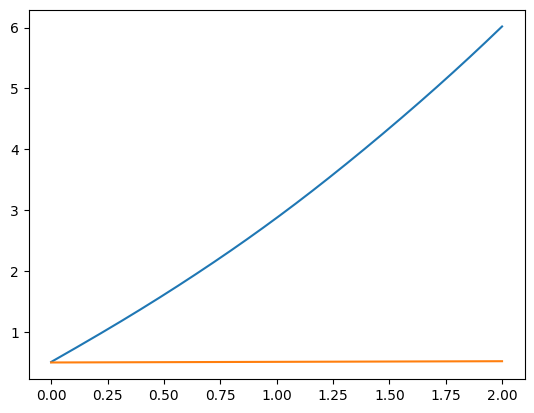

In [17]:
summation = [beta0[0]]
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
for i in range(beta.shape[1]):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g2(curr_beta, T(dt*i)).numpy()[0][0]
    beta_hat[i] = next_beta
    curr_beta = next_beta
    
plt.plot(t, beta_hat)

cn_solver.plot_solutions("soluzione vera")

In [18]:
for i in range(len(t)):
  print(beta_hat[i])

0.508415189743042
0.5168356695175171
0.5252614030838013
0.5336923961639405
0.5421286487579347
0.5505701665878296
0.5590169515609742
0.5674690074920655
0.5759263381958009
0.5843889436721803
0.5928568325042726
0.6013300037384034
0.6098084611892701
0.61829220867157
0.6267812500000002
0.6352755870819093
0.6437752218246462
0.6522802610397341
0.6607907190322878
0.6693065996170046
0.6778279056549074
0.6863546409606935
0.694886808395386
0.7034244117736819
0.71196745300293
0.7205159368515017
0.7290698680877689
0.7376292486190799
0.7461940803527835
0.7547643680572512
0.7633401136398318
0.7719213228225711
0.7805079975128176
0.7891001424789431
0.7976977596282961
0.8063008518218997
0.8149094238281253
0.8235234775543215
0.8321430177688601
0.8407680473327639
0.8493985691070559
0.858034588813782
0.8666761064529422
0.8753231287002567
0.8839760351181034
0.8926359052658085
0.9013027458190922
0.9099765625000004
0.9186573610305789
0.9273451461791995
0.9360399246215824
0.944741701126099
0.9534504814147953
0

## Prova

loss: 0.054779 
loss: 0.053413 
loss: 0.052066 
loss: 0.050739 
loss: 0.049431 


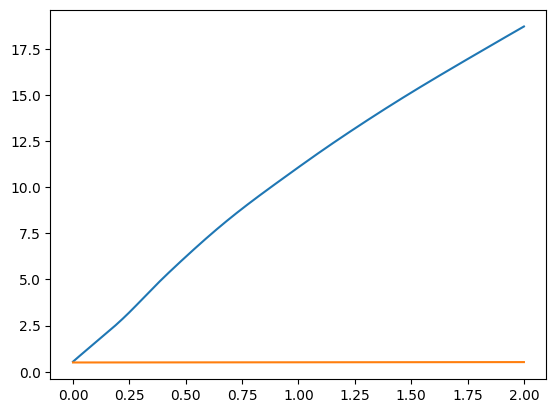

In [ ]:
f0 = 1
inf_s = np.sqrt(np.finfo(np.float32).eps)
learning_rate = 0.01
training_steps = 50
batch_size = 100
display_step = 10
# Network Parameters
n_input = 2     # input layer number of neurons
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons
weights = {
'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
'b1': tf.Variable(tf.random.normal([n_hidden_1])),
'b2': tf.Variable(tf.random.normal([n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_output]))
}
# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Create model
def multilayer_perceptron(x):
  x = np.array([[[x]]],  dtype='float32')
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  layer_1 = tf.nn.sigmoid(layer_1)
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  layer_2 = tf.nn.sigmoid(layer_2)
  output = tf.matmul(layer_2, weights['out']) + biases['out']
  return output
# Universal Approximator
def g(beta, T):
    x = np.array([beta, T])
    #return x * multilayer_perceptron(x)
    return multilayer_perceptron(x)
# Given EDO
tau = 365.

def beta_eq(T):
    return (35 - T)/T
def T(t):
    return math.exp(-(t - 180)**2/(2*80**2))/(math.sqrt(2*math.pi)*80)*300*5*2.6 + 5 
def dbeta(beta, t):
    return 1/tau*(beta_eq(T(t)) - beta[0])
def dbeta_hat(beta, t):
    return g(beta[0], T(t))
    
sys = [dbeta]    

def f(x):
  return 2*x
# Custom loss function to approximate the derivatives
"""
def custom_loss():
  summation = []
  t_max=1.0
  N=50
  beta0=np.array([0.5])
  cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
  cn_solver.compute_solution()
  t, beta = cn_solver.get_solution()
  sys_hat=[dbeta_hat]
  cn_solver_hat = cnc.CrankNicolson(sys_hat, beta0, t_max, N)
  cn_solver_hat.compute_solution()
  t, beta_hat = cn_solver_hat.get_solution()
  for i in range(len(beta)):
      summation.append( ( beta[i] - beta_hat[i] )**2 )
  return tf.sqrt(tf.reduce_mean(tf.abs(summation)))
"""

t_max=2.0
N=500
beta0=np.array([0.5])
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
dt = t_max /N

def custom_loss():
    curr_beta = beta0[0]
    next_beta = curr_beta
    summation = []
    for i in range(len(beta)):
        x = np.array([curr_beta, T(i*dt)])
        next_beta = curr_beta + dt * multilayer_perceptron( x )
        summation.append( dt*(beta[i] - next_beta)**2 )
        curr_beta = next_beta
    return tf.sqrt(tf.reduce_sum(tf.abs(summation)))

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables=list(weights.values())+list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
# Training the Model:
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss()))

summation = [beta0[0]]
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
for i in range(beta.shape[1]):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g( curr_beta, T(dt*i) ).numpy()[0][0][0][0]
    beta_hat[i] = next_beta
    curr_beta = next_beta
    
plt.plot(t, beta_hat)

cn_solver.plot_solutions("soluzione vera")


In [ ]:
for i in range(len(t)):
  print(beta_hat[i] - )

0.4825128479003906
0.4651818313598633
0.4480051326751709
0.430980899810791
0.4141072311401367
0.3973822078704834
0.38080386734008786
0.36437023735046387
0.3480793170928955
0.33192909240722657
0.3159175395965576
0.3000426187515259
0.2843022880554199
0.2686945009231567
0.2532172117233276
0.23786837673187253
0.22264595508575435
0.2075479173660278
0.19257223510742183
0.17771689987182612
0.16297991180419916
0.1483592853546142
0.1338530597686767
0.11945928096771234
0.105176022529602
0.09100137138366693
0.07693344402313226
0.06297037792205805
0.049110332489013614
0.035351491928100526
0.021692068099975526
0.008130294799804627
-0.005335564613342347
-0.018707216262817447
-0.03198635101318366
-0.045174619674682684
-0.058273648262024
-0.07128503608703621
-0.08421035671234138
-0.09705115127563484
-0.10980893421173103
-0.12248519325256355
-0.13508138465881356
-0.14759894275665292
-0.1600392656326295
-0.17240372848510752
-0.18469368076324472
-0.19691043949127207
-0.20905530071258555
-0.22112953186035